In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, concatenate, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Permute, Reshape
from keras.optimizers import Adam
from keras.regularizers import l2
import numpy as np
import cv2
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
batch_size = 128
num_classes = 10
epochs = 2
learning_rate = 0.001

# input image dimensions
img_rows, img_cols = 28, 28
input_shape = (28, 28,1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.reshape(10000,28,28,1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# normalize inputs from 0-255 to 0-1
x_train/=255
x_test/=255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [3]:
def share_stream(x_shape):
    #x = Input(shape=x_shape)
    x=x_shape

    conv1 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    conv1 = Activation('relu')(conv1)
    conv1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(conv1)

    conv2 = Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same')(conv1)
    conv2 = Activation('relu')(conv2)
    conv2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(conv2)

    #shared_layer = Model(x, conv2)
    return conv2 #shared_layer

In [4]:
def model(input_shape):
    
    inputs = Input(shape=input_shape)
    #print("INPUTs:", inputs.shape)

    Conv1 = Conv2D(32, (3, 3),activation='relu', padding='same')(inputs)
    Conv1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(Conv1)

    Conv3_1 = share_stream(x_shape=Conv1)
    Conv3_2 = share_stream(x_shape=Conv1)

    cnn_out = concatenate([Conv3_1, Conv3_2])
    
    cnn_out_flat = Flatten()(cnn_out)
    
    fc_1 = Dense(units=1000, activation='relu')(cnn_out_flat)   
    #fc_1 = Dropout(0.2)(fc_1)

    fc_2 = Dense(units=500, activation='relu')(fc_1)    
    fc_2 = Dropout(0.2)(fc_2)

    output_layer = Dense(units=num_classes, activation='softmax')(fc_2)

    network = Model(input=inputs, outputs=output_layer)
    return network

In [5]:
def train_model(network):
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    network.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    network.summary()
    #print("x_train shape", x_train.shape)
    #print("y_train shape", y_train.shape)
    #print("x_test shape", x_test.shape)
    #print("y_test shape", y_test.shape)
    network.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))
    score = network.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    # Save the model
    network.save('postmates_x.h5')
    json_config = network.to_json()
    return json_config

In [6]:
network = model(input_shape)

C:\Users\Sertan\Anaconda3\envs\sim_test\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


In [7]:
conf=train_model(network)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 14, 14, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_4 (

### Testing Accuracy 

In [8]:
# Testing all images to get the accuracy
score = network.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.025084444355724555
Test accuracy: 0.9918


### TEST IMAGES for trained network

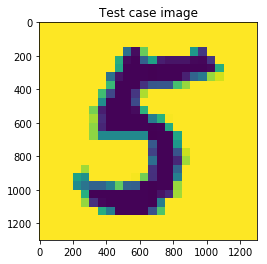

In [9]:
img = cv2.imread(".\\test_images\\mnist_test_1.png",0)
fig, ax = plt.subplots(ncols=1, nrows=1)  ###
ax.imshow(img)
plt.title("Test case image")
plt.show()

### Prediction of the test image

In [10]:
# Do prediction
img = cv2.imread(".\\test_images\\mnist_test_1.png",0)
img = img.astype('float32')/255
img = cv2.resize(img, (28,28))
img = np.reshape(img, (28,28,1))

prediction = network.predict(np.array([img,]))
result=prediction.argmax()
print("Predicted test case image: {}".format(result))

Predicted test case image: 5


In [ ]:
#######################################################33